Jupyter notebook to test the functionality of QBE on classical computer

- Author: Arkopal Dutt
- Last modified: 10 July, 2022

In [1]:
# Imports
import os, sys, types
import pathlib
from importlib import reload
import pickle
import copy

import numpy as np
from matplotlib import pyplot as plt
import qiskit.quantum_info as qi
import h5py

In [2]:
# Local package imports
# Update this with setup & develop later
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [3]:
# Cool reloading
# Reference: https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

In [4]:
import qbe

/Users/arkopal/miniconda3/envs/qbe-qiskit/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# 1. 4-qubit toy problem

## Hamiltonian of interest

In [6]:
# toy problem
num_qubits = 3

H1 = np.load('frag_A_4qubit.npy')
H2 = np.load('frag_B_4qubit.npy')
full_H = np.load('full_H_4qubit.npy')

In [7]:
# Fragment information
n_frags = 2
n_qubits = 3

labels_fragments = ['0', '1']
fragment_info = {'0': [0,1,2], '1': [0,1,2]}
fragment_nb = {'0':{'1': {'n_sites': 1, 'edge': [(2,1)], 'center': [(1,0)]} }, 
               '1':{'0': {'n_sites': 1, 'edge': [(0,1)], 'center': [(1,2)]} }}

fragment_H_init = {'0': H1.copy(), '1': H2.copy()}

#lagrange_multipliers = {'0':{'1': 0}, '1':{'0': 0}}
#rhoEA_minus_rhoCB = {'0':{'1': [np.matrix(np.zeros(2**num_qubits))]}, '1':{'0': [np.matrix(np.zeros(2**num_qubits))]}}

In [8]:
qbe_fragment_init = qbe.fragment_hamiltonian.qbe_fragment_qubit(n_frags, n_qubits, labels_fragments,
                                                                fragment_info, 
                                                                fragment_nb, fragment_H_init)

In [9]:
qbe_fragment_init.gs_energies

{'0': -1.3018744287964985, '1': -1.4517648157734904}

## Functions to update the fragment

In [10]:
def self_consistent_solver(fragment, fragment_hamiltonian, num_self_consistent_steps, lagrange_multipliers):

    for step in range(num_self_consistent_steps):
        self_cons_ham = fragment_hamiltonian
        for f in fragments:
            for adjacent in fragment_overlap[f]:
                for i in range(len(rhoEA_minus_rhoCB[f][adjacent])):
                    self_cons_ham += 2 * lagrange_multipliers[f][adjacent] * rhoEA_minus_rhoCB[f][adjacent][i]

                    eigvals, eigvec = np.linalg.eigh(self_cons_ham)
                    
        ground_state_energy = eigvals[0]
        ground_state = eigvec[:,0]
        ground_state = qi.DensityMatrix(qi.Statevector(ground_state))
        
        
        for adjacent in fragment_overlap[fragment]:
            rho_edge = []
            rho_center = []
            rho_difference = []
            for site in fragment_overlap[fragment][adjacent]:
                indices_to_trace = list(set(range(num_qubits)) - {site[0]})
                rho_edge.append(np.matrix(qi.partial_trace(ground_state, indices_to_trace)))

                indices_to_trace = list(set(range(num_qubits)) - {site[1]})
                rho_center.append(np.matrix(qi.partial_trace(fragment_gs[adjacent], indices_to_trace)))

                rho_difference.append(construct_update_matrix(rho_center[-1]-rho_edge[-1], site))
                
            rhoEA_minus_rhoCB[f][adjacent] = rho_difference    
            
    return ground_state_energy, ground_state

## Non-consistent solver -- quadratic constraint

In [19]:
reload_package(qbe)

In [20]:
qbe_fragment_quad = copy.deepcopy(qbe_fragment_init)

In [21]:
# func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(n_iter/2.9)) # for n_gd_iters=100
func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(n_iter/20))

optimizer_options = {'max_iters': 150, 'LR_init': 1.0, 
                     'LR_schedule': func_updating_LR,
                     'n_gd_iters': 1, 'THRES_GRAD': 1e-8}

qbe_solver_quad = qbe.quantum_bootstrap.qbe_solver_qubit(qbe_fragment_quad, type_constraint='quadratic',
                                                        optimizer_options=optimizer_options)

In [22]:
ds = qbe_solver_quad.gd_solve()

Iter. number: 0
Iter. number: 1
Iter. number: 2
Iter. number: 3
Iter. number: 4
Iter. number: 5
Iter. number: 6
Iter. number: 7
Iter. number: 8
Iter. number: 9
Iter. number: 10
Iter. number: 11
Iter. number: 12
Iter. number: 13
Iter. number: 14
Iter. number: 15
Iter. number: 16
Iter. number: 17
Iter. number: 18
Iter. number: 19
Iter. number: 20
Iter. number: 21
Iter. number: 22
Iter. number: 23
Iter. number: 24
Iter. number: 25
Iter. number: 26
Iter. number: 27
Iter. number: 28
Iter. number: 29
Iter. number: 30
Iter. number: 31
Iter. number: 32
Iter. number: 33
Iter. number: 34
Iter. number: 35
Iter. number: 36
Iter. number: 37
Iter. number: 38
Iter. number: 39
Iter. number: 40
Iter. number: 41
Iter. number: 42
Iter. number: 43
Iter. number: 44
Iter. number: 45
Iter. number: 46
Iter. number: 47
Iter. number: 48
Iter. number: 49
Iter. number: 50
Iter. number: 51
Iter. number: 52
Iter. number: 53
Iter. number: 54
Iter. number: 55
Iter. number: 56
Iter. number: 57
Iter. number: 58
Iter. n

In [23]:
qbe_fragment_init.gs_energies

{'0': -1.3018744287964985, '1': -1.4517648157734904}

In [24]:
qbe_fragment_quad.gs_energies

{'0': -1.1248620676542462, '1': -1.2386593684129252}

In [29]:
n_eig_calls_quad = ds['n_eig_calls']
norm_gradients_quad = ds['norm_gradients']
rmse_error_quad = ds['rmse_error_fragment_rho']

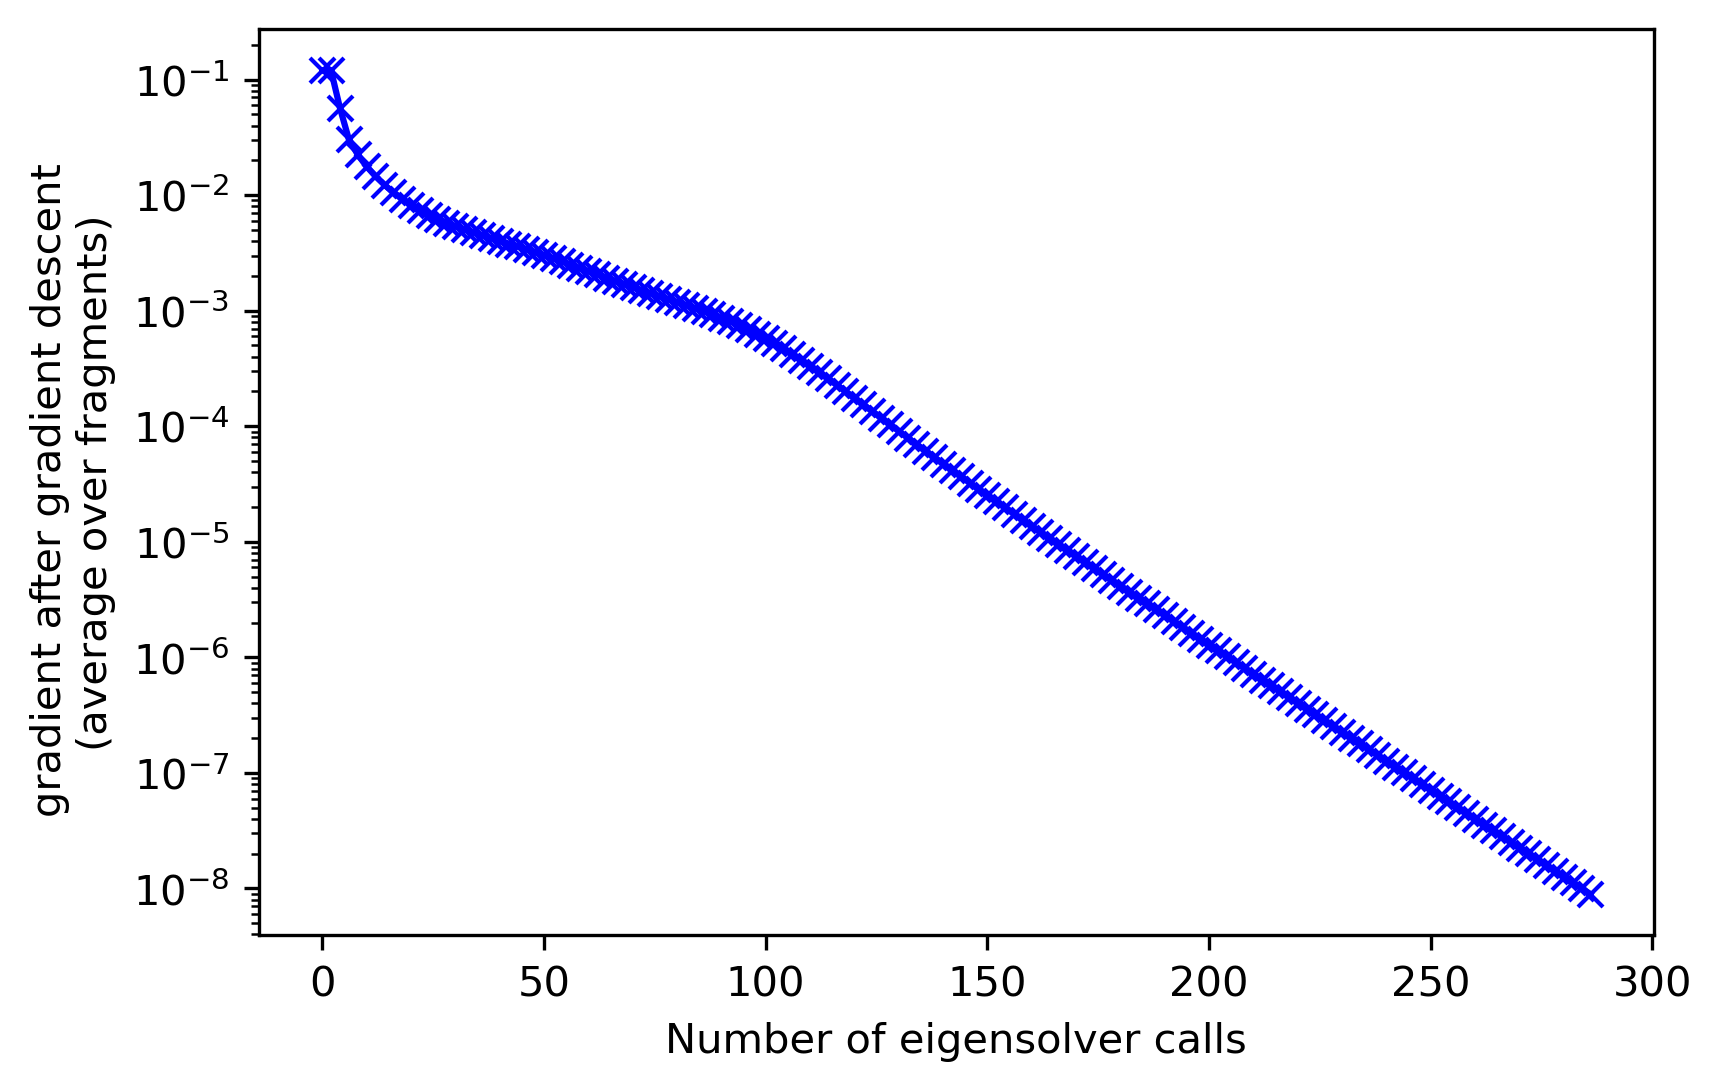

In [28]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_quad, norm_gradients_quad, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.savefig('quadratic_lr_cool.png', bbox_inches='tight')

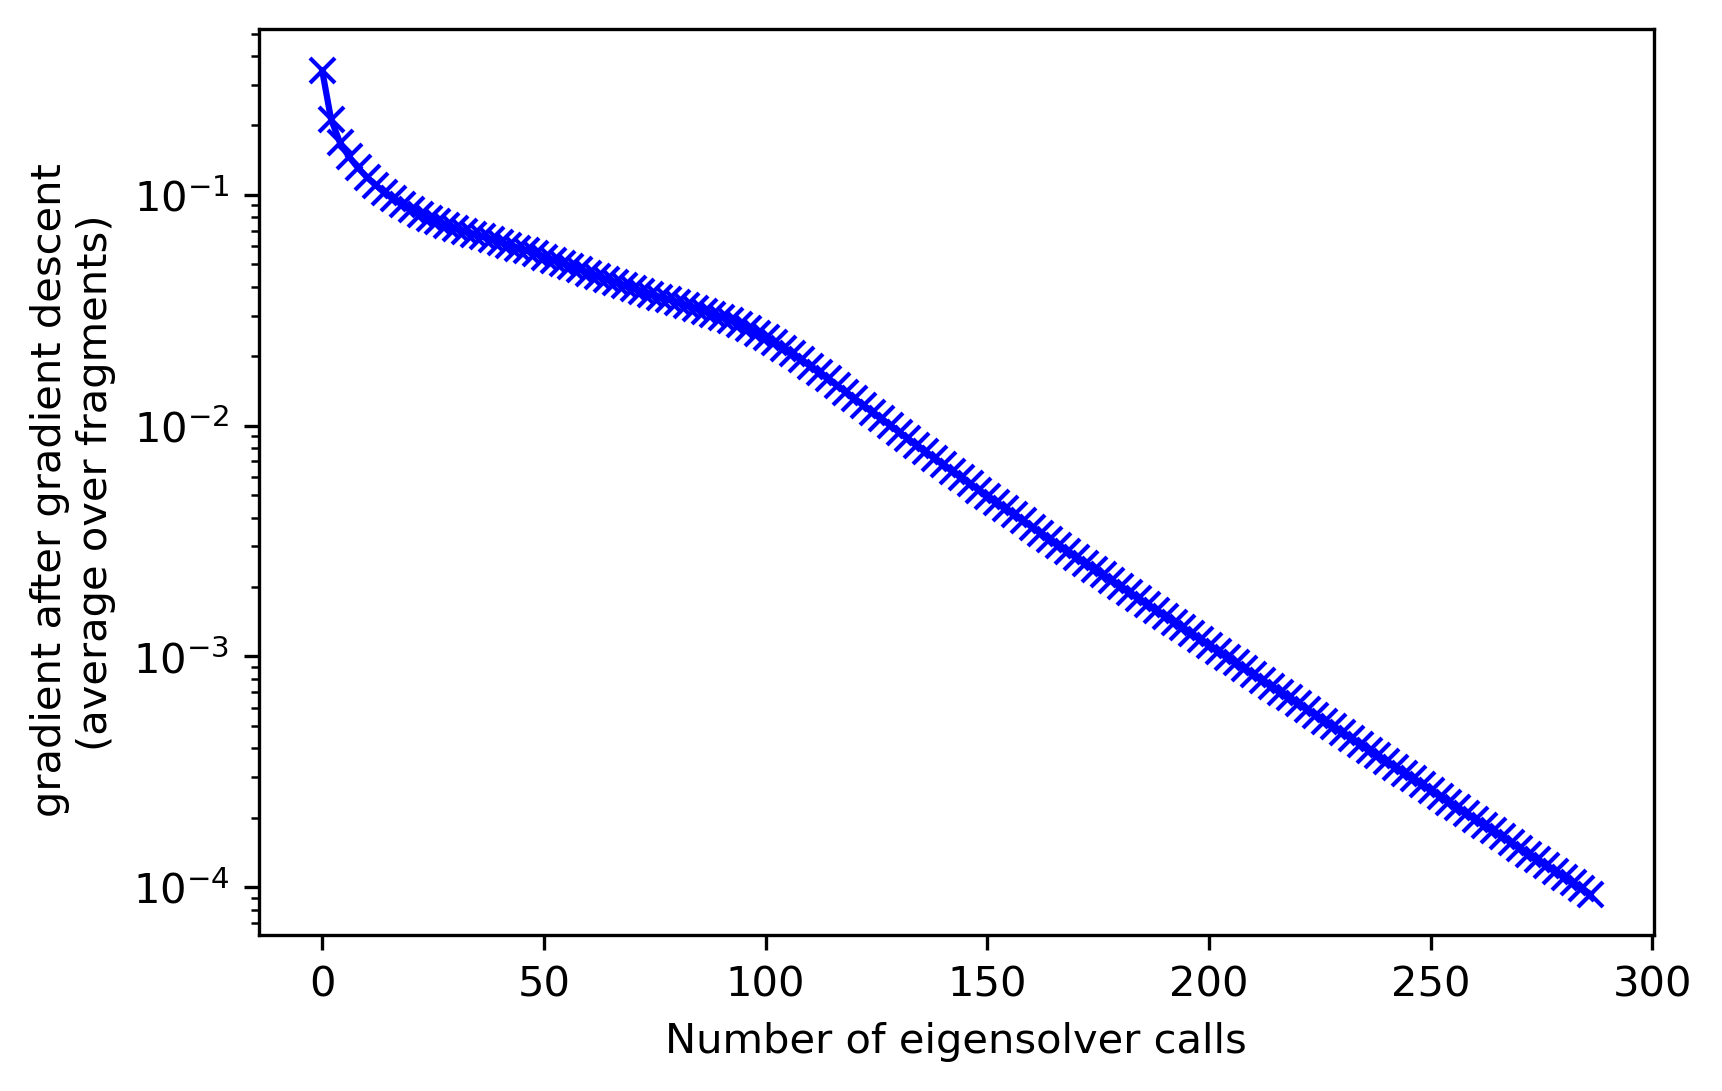

In [30]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_quad, rmse_error_quad, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.savefig('quadratic_lr_cool.png', bbox_inches='tight')

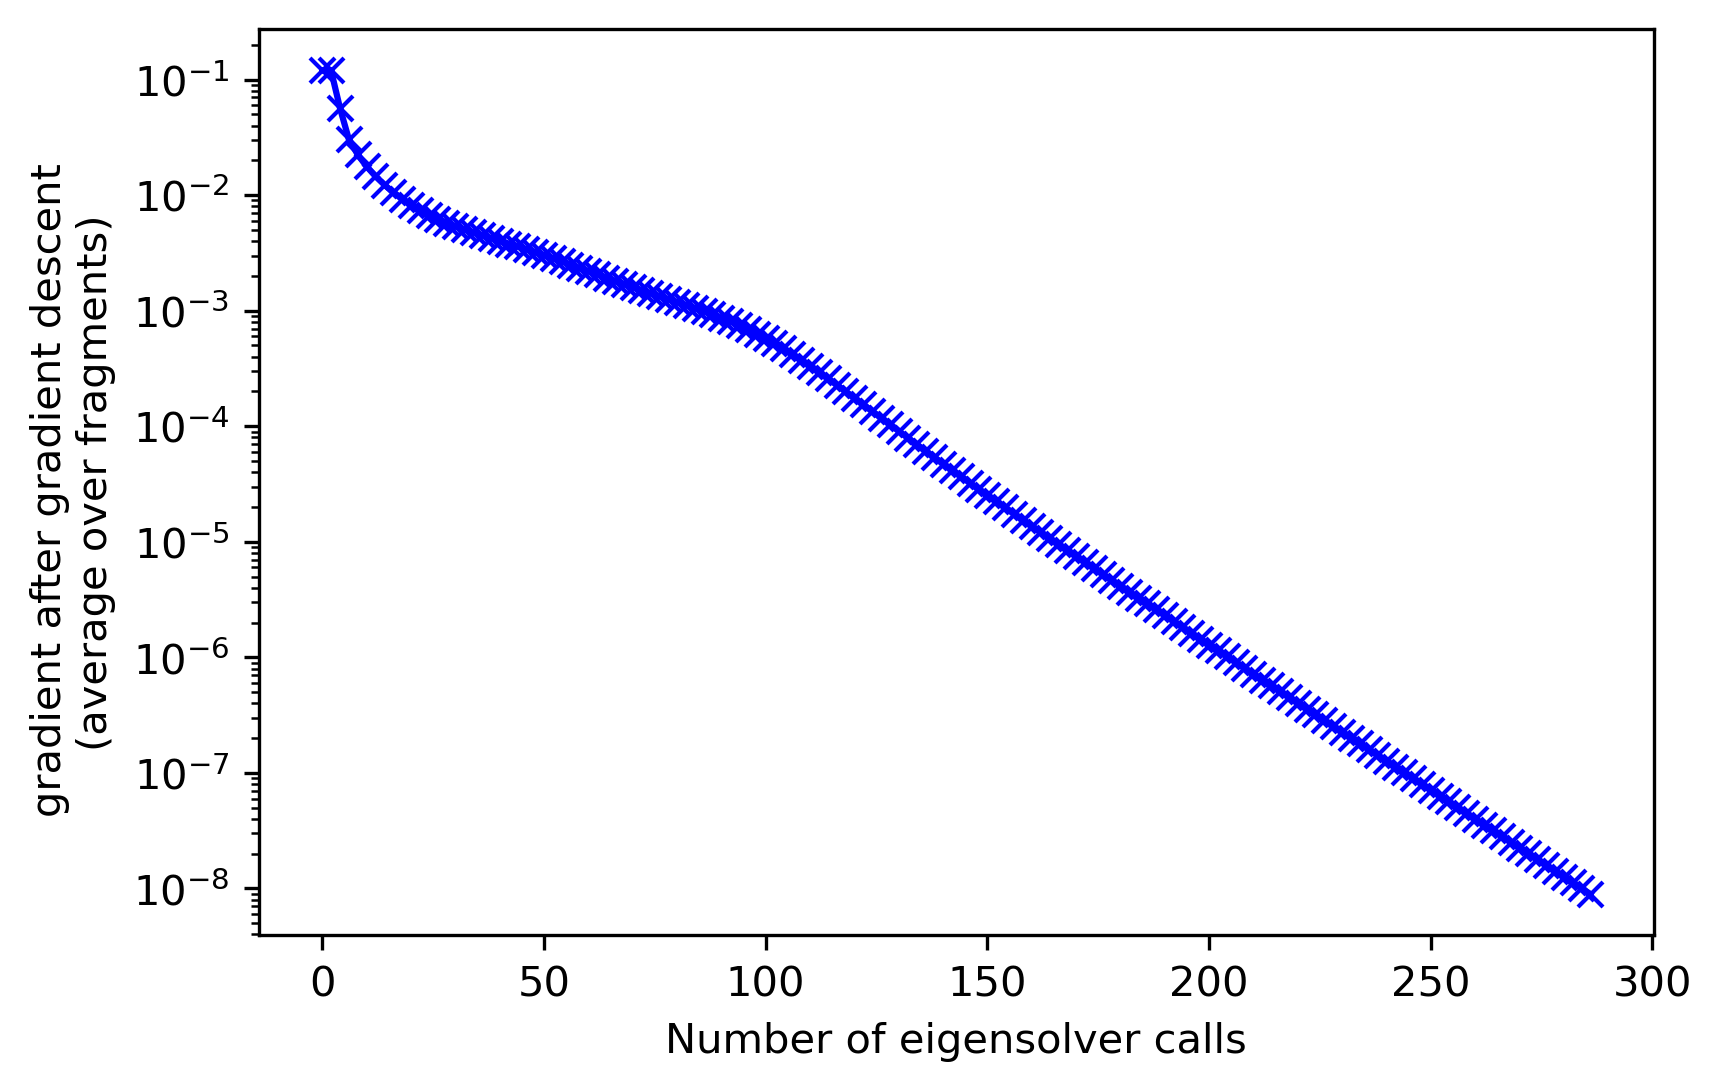

In [19]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_quad, norm_gradients_quad, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.savefig('quadratic_lr_cool.png', bbox_inches='tight')

## GD Solver -- linear constraint

Questions:
- Can delta_lambda be complex?
- How is lambda actually used? I only see the use of delta_lambda.
- If we use the linear constraint aka trace condition, don't we just get 0?
- Would be nice to have the discretized equations actually used in the algorithm and not just the working equations.
- I can write up a "Numerical" section if required.

Problems:
- rho_C should be updated
- Tr(P rho) <= 1

In [20]:
reload_package(qbe)

In [21]:
qbe_fragment_init.gs_energies

{'0': -1.3018744287964985, '1': -1.4517648157734904}

In [22]:
qbe_fragment_init.H['0'].shape

(8, 8)

In [23]:
qbe_fragment_lin = copy.deepcopy(qbe_fragment_init)

In [24]:
func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(-n_iter/50))

optimizer_options = {'max_iters': 150, 'LR_init': 0.1, 
                     'LR_schedule': None,
                     'n_gd_iters': 10, 'THRES_GRAD': 1e-9}
qbe_solver_lin = qbe.quantum_bootstrap.qbe_solver_qubit(qbe_fragment_lin, type_constraint='linear',
                                                       optimizer_options=optimizer_options)

In [25]:
qbe_fragment_lin.gs_energies

{'0': -1.3018744287964985, '1': -1.4517648157734904}

In [26]:
qbe_fragment_lin.rho_E

{'0': {'1': [matrix([[ 0.61784751+0.j        , -0.0111165 +0.38122997j],
           [-0.0111165 -0.38122997j,  0.38215249+0.j        ]])]},
 '1': {'0': [matrix([[ 0.35876405+0.j        , -0.2523094 -0.23553534j],
           [-0.2523094 +0.23553534j,  0.64123595+0.j        ]])]}}

In [27]:
qbe_fragment_lin.sigma_rho_E

{'0': {'1': [array([-0.022233  , -0.76245994,  0.23569502])]},
 '1': {'0': [array([-0.5046188 ,  0.47107067, -0.28247189])]}}

In [28]:
qbe_fragment_lin.sigma_rho_C

{'0': {'1': [array([-0.59969849, -0.07726596, -0.13341851])]},
 '1': {'0': [array([-0.31013234, -0.64989462,  0.0054492 ])]}}

In [29]:
qbe_solver_lin.delta_lambda

{'0': {'1': array([ 0.28789934, -0.11256531,  0.23024581])},
 '1': {'0': array([ 0.09507969,  0.54833663, -0.14905338])}}

In [30]:
run_lin, norm_gradients_lin, n_eig_calls_lin = qbe_solver_lin.gd_solve()

Iter. number: 0
Iter. number: 1
Iter. number: 2
Iter. number: 3
Iter. number: 4
Iter. number: 5
Iter. number: 6
Iter. number: 7
Iter. number: 8
Iter. number: 9
Iter. number: 10
Iter. number: 11
Iter. number: 12
Iter. number: 13
Iter. number: 14
Iter. number: 15
Iter. number: 16
Iter. number: 17
Iter. number: 18
Iter. number: 19
Iter. number: 20
Iter. number: 21
Iter. number: 22
Iter. number: 23
Iter. number: 24
Iter. number: 25
Iter. number: 26
Iter. number: 27
Iter. number: 28
Iter. number: 29
Iter. number: 30
Iter. number: 31
Iter. number: 32
Iter. number: 33
Iter. number: 34
Iter. number: 35
Iter. number: 36
Iter. number: 37
Iter. number: 38
Iter. number: 39
Iter. number: 40
Iter. number: 41
Iter. number: 42
Iter. number: 43
Iter. number: 44
Iter. number: 45
Iter. number: 46
Iter. number: 47
Iter. number: 48
Iter. number: 49
Iter. number: 50
Iter. number: 51
Iter. number: 52
Iter. number: 53
Iter. number: 54
Iter. number: 55
Iter. number: 56
Iter. number: 57
Iter. number: 58
Iter. n

In [31]:
qbe_solver_lin.delta_lambda

{'0': {'1': array([-6.94501678e-10, -1.87902582e-09, -1.91585359e-10])},
 '1': {'0': array([-1.36587319e-09,  1.99454231e-10, -7.57121754e-10])}}

In [32]:
qbe_fragment_lin.gs_energies

{'0': -1.1247209555248916, '1': -1.2384959482153377}

In [33]:
qbe_fragment_init.rho_E

{'0': {'1': [matrix([[ 0.61784751+0.j        , -0.0111165 +0.38122997j],
           [-0.0111165 -0.38122997j,  0.38215249+0.j        ]])]},
 '1': {'0': [matrix([[ 0.35876405+0.j        , -0.2523094 -0.23553534j],
           [-0.2523094 +0.23553534j,  0.64123595+0.j        ]])]}}

In [34]:
qbe_fragment_lin.rho_E

{'0': {'1': [matrix([[ 0.62955767+0.j        , -0.0869619 +0.25479117j],
           [-0.0869619 -0.25479117j,  0.37044233+0.j        ]])]},
 '1': {'0': [matrix([[ 0.3288182 +0.j        , -0.24394485+0.01463634j],
           [-0.24394485-0.01463634j,  0.6711818 +0.j        ]])]}}

In [35]:
qbe_fragment_init.rho_C

{'0': {'1': [matrix([[ 0.43329074+0.j        , -0.29984925+0.03863298j],
           [-0.29984925-0.03863298j,  0.56670926+0.j        ]])]},
 '1': {'0': [matrix([[ 0.5027246 +0.j        , -0.15506617+0.32494731j],
           [-0.15506617-0.32494731j,  0.4972754 +0.j        ]])]}}

In [36]:
qbe_fragment_lin.rho_C

{'0': {'1': [matrix([[ 0.3288182 +0.j        , -0.24394485+0.01463634j],
           [-0.24394485-0.01463634j,  0.6711818 +0.j        ]])]},
 '1': {'0': [matrix([[ 0.62955767+0.j        , -0.0869619 +0.25479116j],
           [-0.0869619 -0.25479116j,  0.37044233+0.j        ]])]}}

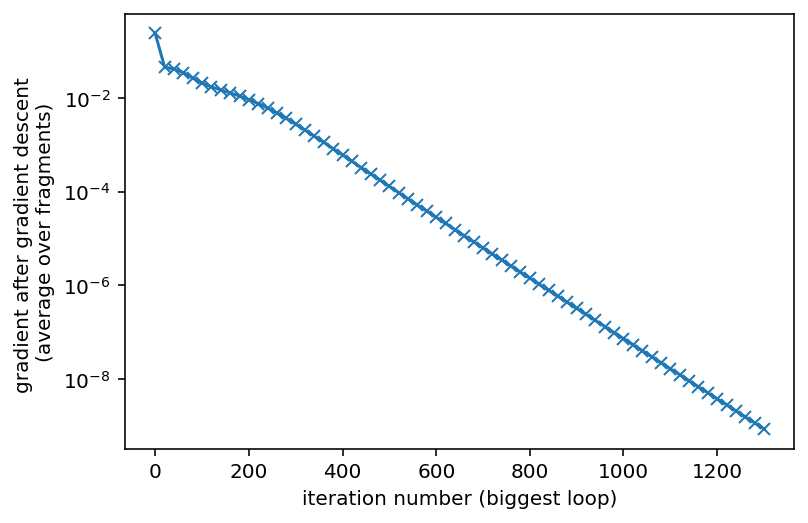

In [37]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_lin, norm_gradients_lin, '-x')
plt.xlabel('iteration number (biggest loop)')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.savefig('linear_constraint_lr0_05.png', bbox_inches='tight')

## Summary

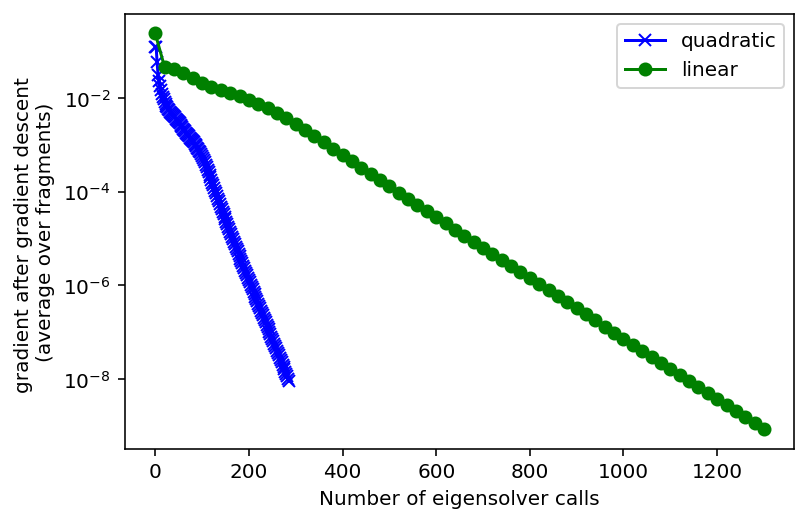

In [38]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_quad, norm_gradients_quad, '-x', c='b', label='quadratic')
plt.semilogy(n_eig_calls_lin, norm_gradients_lin, '-o', c='g', label='linear')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.legend(loc='upper right')
plt.savefig('comparison_toy_problem.png', bbox_inches='tight')

# 2. H4 chain

## Fragment Hamiltonians -- initialization

In [128]:
reload_package(qbe)

In [129]:
def init_fragment_hamiltonians(fragments,hamiltonian_data):
    '''
    initialize a dictionary where the keys are fragment labels 
    and the values are the corresponding fragment Hamiltonian matrices
    '''
    fragment_hamiltonians = {}
    for i in range(len(fragments)):
        fragment_hamiltonians[str(i)] = np.matrix(hamiltonian_data['i0f'+str(i)])
    return fragment_hamiltonians

In [130]:
DATA_dir = '../data/'
hamiltonian_file = 'H4_inital_ham.h5'

hamiltonian_data = h5py.File(DATA_dir + hamiltonian_file, 'r')

In [131]:
# fragment info
n_frags = 2
n_qubits = 8

labels_fragments = ['0', '1']
fragment_info = {'0': [0,1,2,4,5,6],'1': [0,1,2,4,5,6]}
fragment_nb = {'0': {'1': {'n_sites': 2, 'edge': [(2,1),(6,5)], 'center': [(1,0),(5,4)]}}, 
                    '1': {'0': {'n_sites': 2, 'edge': [(0,1),(4,5)], 'center': [(1,2),(5,6)]}}}

In [132]:
fragment_H4_init = init_fragment_hamiltonians(fragment_info, hamiltonian_data)

In [133]:
qbe_frag_H4_init = qbe.fragment_hamiltonian.qbe_fragment_qubit(n_frags, n_qubits, labels_fragments,
                                                                fragment_info, 
                                                                fragment_nb, fragment_H4_init)

## Quadratic constraints -- GD

In [134]:
qbe_frag_quad_H4.rho_C

{'0': {'1': [matrix([[ 0.06583501+0.j, -0.03706196+0.j],
           [-0.03706196+0.j,  0.93416499+0.j]]),
   matrix([[ 2.64165672e-09+0.j, -1.28319746e-07+0.j],
           [-1.28319746e-07+0.j,  9.99999997e-01+0.j]])]},
 '1': {'0': [matrix([[ 1.00000000e+00+0.j, -3.15401889e-26+0.j],
           [-3.15401889e-26+0.j,  1.89181001e-14+0.j]]),
   matrix([[9.70595635e-01+0.j, 2.07210461e-09+0.j],
           [2.07210461e-09+0.j, 2.94043650e-02+0.j]])]}}

In [135]:
qbe_frag_quad_H4 = copy.deepcopy(qbe_frag_H4_init)

In [136]:
#func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(n_iter/2.9)) # for n_gd_iters=100
func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(n_iter/20))

optimizer_options = {'max_iters': 150, 'LR_init': 1.0, 
                     'LR_schedule': func_updating_LR,
                     'n_gd_iters': 1, 'THRES_GRAD': 1e-8}

qbe_solver_quad_H4 = qbe.quantum_bootstrap.qbe_solver_qubit(qbe_frag_quad_H4, type_constraint='quadratic',
                                                            optimizer_options=optimizer_options)

In [137]:
run_quad_H4, norm_gradients_quad_H4, n_eig_calls_quad_H4 = qbe_solver_quad_H4.gd_solve()

Iter. number: 0
Iter. number: 1
Iter. number: 2
Iter. number: 3
Iter. number: 4
Iter. number: 5
Iter. number: 6
Iter. number: 7
Iter. number: 8
Iter. number: 9
Iter. number: 10
Iter. number: 11
Iter. number: 12
Iter. number: 13
Iter. number: 14
Iter. number: 15
Iter. number: 16
Iter. number: 17
Iter. number: 18
Iter. number: 19
Iter. number: 20
Iter. number: 21
Iter. number: 22
Iter. number: 23
Iter. number: 24
Iter. number: 25
Iter. number: 26
Iter. number: 27
Iter. number: 28
Iter. number: 29
Iter. number: 30
Iter. number: 31
Iter. number: 32
Iter. number: 33
Iter. number: 34
Iter. number: 35
Iter. number: 36
Iter. number: 37
Iter. number: 38
Iter. number: 39
Iter. number: 40
Iter. number: 41
Iter. number: 42
Iter. number: 43
Iter. number: 44
Iter. number: 45
Iter. number: 46
Iter. number: 47
Iter. number: 48
Iter. number: 49
Iter. number: 50
Iter. number: 51
Iter. number: 52
Iter. number: 53
Iter. number: 54
Iter. number: 55
Iter. number: 56
Iter. number: 57
Iter. number: 58
Iter. n

In [138]:
qbe_frag_H4_init.gs_energies

{'0': -3.8588128484366213, '1': -5.047673900554894}

In [139]:
qbe_frag_quad_H4.gs_energies

{'0': -3.4594917841480597, '1': -4.959485659481955}

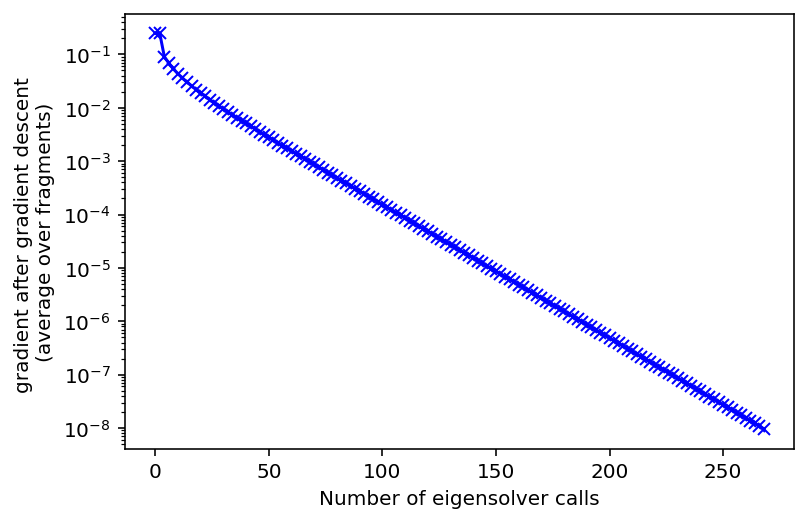

In [141]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_quad_H4, norm_gradients_quad_H4, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.savefig('quadratic_H4.png', bbox_inches='tight')

## Linear constraints -- GD

In [143]:
qbe_frag_lin_H4 = copy.deepcopy(qbe_frag_H4_init)

In [144]:
func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(-n_iter/50))

optimizer_options = {'max_iters': 150, 'LR_init': 0.1, 
                     'LR_schedule': None,
                     'n_gd_iters': 10, 'THRES_GRAD': 1e-9}

qbe_solver_lin_H4 = qbe.quantum_bootstrap.qbe_solver_qubit(qbe_frag_lin_H4, type_constraint='linear',
                                                       optimizer_options=optimizer_options)

In [145]:
run_lin_H4, norm_gradients_lin_H4, n_eig_calls_lin_H4 = qbe_solver_lin_H4.gd_solve()

Iter. number: 0
Iter. number: 1
Iter. number: 2
Iter. number: 3
Iter. number: 4
Iter. number: 5
Iter. number: 6
Iter. number: 7
Iter. number: 8
Iter. number: 9
Iter. number: 10
Iter. number: 11
Iter. number: 12
Iter. number: 13


In [146]:
qbe_frag_H4_init.gs_energies

{'0': -3.8588128484366213, '1': -5.047673900554894}

In [147]:
qbe_frag_lin_H4.gs_energies

{'0': -3.459488695985616, '1': -4.9594886959398155}

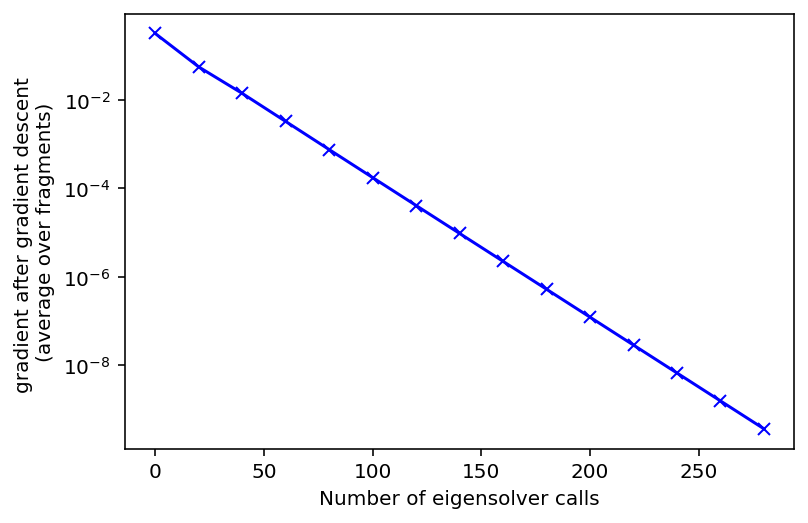

In [148]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_lin_H4, norm_gradients_lin_H4, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.savefig('linear_H4.png', bbox_inches='tight')

## Summary

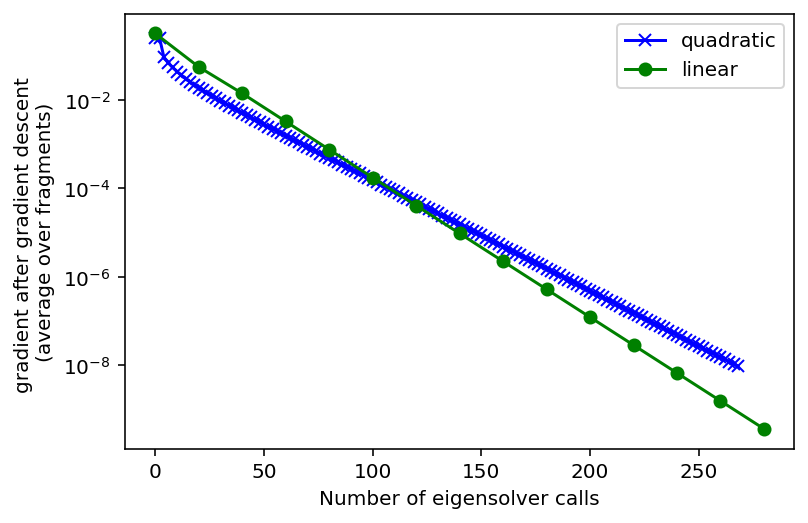

In [149]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_quad_H4, norm_gradients_quad_H4, '-x', c='b', label='quadratic')
plt.semilogy(n_eig_calls_lin_H4, norm_gradients_lin_H4, '-o', c='g', label='linear')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.legend(loc='upper right')
plt.savefig('comparison_H4.png', bbox_inches='tight')

# -1. H8 Chain

## Fragment hamiltonians -- initialization

In [6]:
reload_package(qbe)

In [7]:
def init_fragment_hamiltonians(fragments,hamiltonian_data):
    '''
    initialize a dictionary where the keys are fragment labels 
    and the values are the corresponding fragment Hamiltonian matrices
    '''
    fragment_hamiltonians = {}
    for i in range(len(fragments)):
        fragment_hamiltonians[str(i)] = np.matrix(hamiltonian_data['i0f'+str(i)])
    return fragment_hamiltonians

In [8]:
# # load the Hamiltonian matrices for each fragment
DATA_dir = '../data/'
hamiltonian_file = 'H8_initial_ham.h5'

hamiltonian_data = h5py.File(DATA_dir + hamiltonian_file, 'r')

In [9]:
# fragment info
n_frags = 6
n_qubits = 12 

labels_fragments = ['0', '1','2', '3', '4', '5']

fragment_info = {'0': [0,1,2,6,7,8],'1': [0,1,2,6,7,8],'2': [0,1,2,6,7,8],
                 '3': [0,1,2,6,7,8], '4': [0,1,2,6,7,8], '5': [0,1,2,6,7,8]} 

fragment_nb = {'0': {'1': {'n_sites': 2, 'edge': [(2,1),(8,7)], 'center': [(1,0),(7,6)]}}, 
               
               '1': {'0': {'n_sites': 2, 'edge': [(0,1),(6,7)], 'center': [(1,2),(7,8)]},
                     '2': {'n_sites': 2, 'edge': [(2,1),(8,7)], 'center': [(1,0),(7,6)]}},
               
               '2': {'1': {'n_sites': 2, 'edge': [(0,1),(6,7)], 'center': [(1,2),(7,8)]},
                     '3': {'n_sites': 2, 'edge': [(2,1),(8,7)], 'center': [(1,0),(7,6)]}},
               
               '3': {'2': {'n_sites': 2, 'edge': [(0,1),(6,7)], 'center': [(1,2),(7,8)]},
                     '4': {'n_sites': 2, 'edge': [(2,1),(8,7)], 'center': [(1,0),(7,6)]}},
               
               '4': {'3': {'n_sites': 2, 'edge': [(0,1),(6,7)], 'center': [(1,2),(7,8)]},
                     '5': {'n_sites': 2, 'edge': [(2,1),(8,7)], 'center': [(1,0),(7,6)]}},
               
               '5': {'4': {'n_sites': 2, 'edge': [(0,1),(6,7)], 'center': [(1,2),(7,8)]}}
              }

# fragment_overlap = {'0': {'1': [[2,1],[8,7]]}, 
#                     '1': {'0': [[0,1],[6,7]], '2': [[2,1],[8,7]]},
#                     '2': {'1': [[0,1],[6,7]], '3': [[2,1],[8,7]]},
#                     '3': {'2': [[0,1],[6,7]], '4': [[2,1],[8,7]]},
#                     '4': {'3': [[0,1],[6,7]], '5': [[2,1],[8,7]]}, 
#                     '5': {'4': [[0,1],[6,7]]}}


In [10]:
fragment_H8_init = init_fragment_hamiltonians(fragment_info, hamiltonian_data)

In [11]:
qbe_frag_H8_init = qbe.fragment_hamiltonian.qbe_fragment_qubit(n_frags, n_qubits, labels_fragments,
                                                                fragment_info, 
                                                                fragment_nb, fragment_H8_init)

In [12]:
qbe_frag_H8_init.gs_energies

{'0': -7.402083566639728,
 '1': -7.5506678045984765,
 '2': -7.699138050773046,
 '3': -7.699138050773052,
 '4': -7.5506678045984765,
 '5': -7.402083566639674}

In [13]:
qbe_frag_H8_init.rho_E

{'0': {'1': [matrix([[ 5.01749528e-01+0.j, -1.25376570e-19+0.j],
           [-1.25376570e-19+0.j,  4.98250472e-01+0.j]]),
   matrix([[5.01749528e-01+0.j, 1.10509189e-16+0.j],
           [1.10509189e-16+0.j, 4.98250472e-01+0.j]])]},
 '1': {'0': [matrix([[ 5.10418396e-01+0.j, -9.50802779e-20+0.j],
           [-9.50802779e-20+0.j,  4.89581604e-01+0.j]]),
   matrix([[5.10418396e-01+0.j, 3.59462352e-17+0.j],
           [3.59462352e-17+0.j, 4.89581604e-01+0.j]])],
  '2': [matrix([[ 5.02531691e-01+0.j, -8.23754441e-20+0.j],
           [-8.23754441e-20+0.j,  4.97468309e-01+0.j]]),
   matrix([[5.02531691e-01+0.j, 7.83741597e-18+0.j],
           [7.83741597e-18+0.j, 4.97468309e-01+0.j]])]},
 '2': {'1': [matrix([[ 5.01292717e-01+0.j, -1.50500414e-17+0.j],
           [-1.50500414e-17+0.j,  4.98707283e-01+0.j]]),
   matrix([[ 5.01292717e-01+0.j, -9.57592362e-16+0.j],
           [-9.57592362e-16+0.j,  4.98707283e-01+0.j]])],
  '3': [matrix([[ 5.03827541e-01+0.j, -1.02129000e-17+0.j],
           [-1.

## Quadratic constraints -- GD

## Linear constraints -- GD

In [32]:
reload_package(qbe)

In [33]:
qbe_frag_lin_H8 = copy.deepcopy(qbe_frag_H8_init)

In [29]:
func_updating_LR = lambda LR_init, n_iter: LR_init*(10**(-n_iter/50))

optimizer_options = {'max_iters': 15, 'LR_init': 0.1, 
                     'LR_schedule': None,
                     'n_gd_iters': 1, 'THRES_GRAD': 1e-9}

qbe_solver_lin_H8 = qbe.quantum_bootstrap.qbe_solver_qubit(qbe_frag_lin_H8, type_constraint='linear',
                                                           optimizer_options=optimizer_options)

In [30]:
run_lin_H8, norm_gradients_lin_H8, n_eig_calls_lin_H8 = qbe_solver_lin_H8.gd_solve()

Iter. number: 0


KeyboardInterrupt: 

In [147]:
qbe_frag_lin_H4.gs_energies

{'0': -3.459488695985616, '1': -4.9594886959398155}

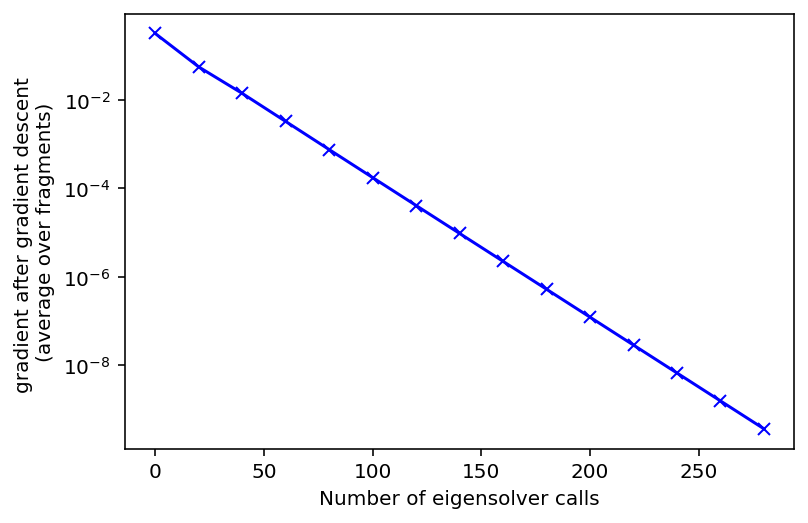

In [148]:
plt.figure(dpi = 150)
plt.semilogy(n_eig_calls_lin_H4, norm_gradients_lin_H4, '-x', c='b')
#plt.xlabel('iteration number (biggest loop)')
plt.xlabel('Number of eigensolver calls')
plt.ylabel('gradient after gradient descent \n(average over fragments)')
plt.savefig('linear_H4.png', bbox_inches='tight')